# Estimating Distribution of Residuals


- Read Data
- Add resifuals
- Use `pymc` to learn distribution of residuals from reference dataset
- Sample learnt residual distribution to estimate error on analysis dataset
- Compare results with actual error calculations

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures

import pymc as pm
import arviz as az

import multiprocessing as mp
mp.set_start_method('forkserver')

In [2]:
pm.__version__

'4.1.3'

In [3]:
data = pd.read_csv("data.csv")
data.head()

,feature1,feature2,feature3,feature4,partition,y_true,y_std,y_pred,timestamp
0,1.220802,2.190876,0.360013,3.292751,train,-14.210923,10.842207,1.804019,2020-01-01 00:00:00.000
1,0.461790,3.782660,2.599774,3.282467,train,19.331988,10.774591,7.361359,2020-01-01 00:01:40.800
2,3.711265,-2.599387,-3.467779,0.871672,train,-11.321392,0.759812,-9.831324,2020-01-01 00:03:21.600
3,1.448967,-0.240156,0.446262,-2.591261,train,1.631834,6.714633,-0.627180,2020-01-01 00:05:02.400
4,-0.106896,-0.737643,-0.548846,-1.156195,train,0.604102,1.336787,-0.904592,2020-01-01 00:06:43.200


In [4]:
data = data.assign(residual=lambda x: x.y_true - x.y_pred)
data

,feature1,feature2,feature3,feature4,partition,y_true,y_std,y_pred,timestamp,residual
0,1.220802,2.190876,0.360013,3.292751,train,-14.210923,10.842207,1.804019,2020-01-01 00:00:00.000,-16.014942
1,0.461790,3.782660,2.599774,3.282467,train,19.331988,10.774591,7.361359,2020-01-01 00:01:40.800,11.970629
2,3.711265,-2.599387,-3.467779,0.871672,train,-11.321392,0.759812,-9.831324,2020-01-01 00:03:21.600,-1.490067
3,1.448967,-0.240156,0.446262,-2.591261,train,1.631834,6.714633,-0.627180,2020-01-01 00:05:02.400,2.259014
4,-0.106896,-0.737643,-0.548846,-1.156195,train,0.604102,1.336787,-0.904592,2020-01-01 00:06:43.200,1.508694
...,...,...,...,...,...,...,...,...,...,...
179995,1.029423,0.818893,-0.182306,0.399978,analysis,0.508124,0.159983,0.404815,2020-07-28 23:51:36.000,0.103309
179996,-0.489689,1.660527,0.520562,0.048241,analysis,4.047932,0.002327,3.985596,2020-07-28 23:53:16.800,0.062336
179997,-1.603126,-3.259720,-1.519413,-1.670753,analysis,-6.851495,2.791414,-4.136851,2020-07-28 23:54:57.600,-2.714644
179998,0.604372,1.123468,2.184232,2.148200,analysis,4.991351,4.614764,2.125917,2020-07-28 23:56:38.400,2.865433


In [5]:
reference = data.loc[
    data.partition == 'reference',
    # ['timestamp', 'feature1', 'feature2', 'feature3', 'feature4', 'y_pred', 'y_true', 'residual']
].reset_index(drop=True)
reference.head()

,feature1,feature2,feature3,feature4,partition,y_true,y_std,y_pred,timestamp,residual
0,-1.169727,0.755738,-1.803664,0.670377,reference,1.242007,0.449406,1.393271,2020-03-11 00:00:00.000,-0.151264
1,-3.526384,3.328349,0.044730,-1.269115,reference,10.246239,1.610652,10.066246,2020-03-11 00:01:40.800,0.179992
2,-1.461347,-0.788103,3.696154,-3.488497,reference,-8.795591,12.169612,2.978791,2020-03-11 00:03:21.600,-11.774383
3,0.583206,-1.385951,0.497757,-0.807896,reference,-2.094817,0.652696,-2.767681,2020-03-11 00:05:02.400,0.672864
4,-1.334035,0.830657,2.055350,-3.078183,reference,-1.636014,9.475209,5.042562,2020-03-11 00:06:43.200,-6.678577


In [6]:
poly = PolynomialFeatures(degree=1)
features = ['feature1', 'feature2', 'feature3', 'feature4', 'y_pred']

Xin = poly.fit_transform(reference[features])

y = reference.residual.to_numpy()

In [7]:
def construct_model(X: np.ndarray, y: np.ndarray):
    xdim = X.shape[1]
    
    init_1 = np.random.normal(loc=0, scale=1, size=xdim)
    init_2 = np.random.normal(loc=0, scale=1, size=xdim)

    with pm.Model() as model:
        # set data objects
        X = pm.Data("X", X, mutable=True)
        RS = pm.Data("RS", y, mutable=True)

        # Priors for unknown model parameters
        alpha = pm.Normal("alpha", sigma=50, shape=(xdim,), initval=init_1)
        beta = pm.Normal("beta", sigma=50, shape=(xdim,), initval=init_2)

        mu = pm.math.dot(X, alpha)
        sigma = np.exp(pm.math.dot(X, beta))
        
        # Likelihood (sampling distribution) of observations
        residual = pm.Normal(
            "residual",
            mu=mu,
            sigma=sigma,
            observed=RS
        )

    return model

In [8]:
model = construct_model(X=Xin, y=y)

In [9]:
DRAWS_SAMPLE_SIZE = 1000
CHAINS_NUMBER = 2

In [10]:
with model:
    trace = pm.sample(
        draws=DRAWS_SAMPLE_SIZE,
        initvals=pm.find_MAP(),
        chains=CHAINS_NUMBER
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 459 seconds.
The acceptance probability does not match the target. It is 0.9209, but should be close to 0.8. Try to increase the number of tuning steps.


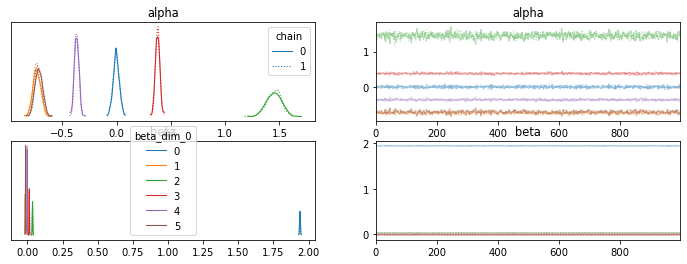

In [11]:
with model:
    az.plot_trace(trace, legend=True)
    # az.plot_trace(trace, var_names=('sigma'))

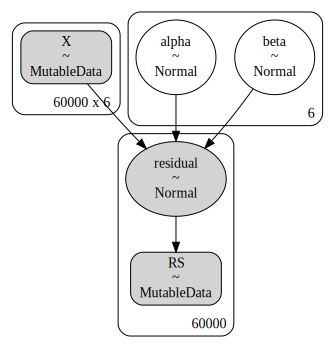

In [12]:
pm.model_to_graphviz(model)

In [13]:
for el in range(trace.posterior['alpha'][0,:,:].shape[1]):
    print(
        f"alpha_{el+1}: {round(trace.posterior['alpha'][0, :, el].to_numpy().mean(), 5)}"
    )
    
for el in range(trace.posterior['beta'][0,:,:].shape[1]):
    print(
        f"beta_{el+1}: {round(trace.posterior['beta'][0, :, el].to_numpy().mean(), 5)}"
    )

alpha_1: -0.00307
alpha_2: -0.73321
alpha_3: 1.45019
alpha_4: 0.37752
alpha_5: -0.36732
alpha_6: -0.71629
beta_1: 1.93859
beta_2: -0.01614
beta_3: 0.03578
beta_4: 0.0124
beta_5: -0.00135
beta_6: -0.01346


In [14]:
analysis = data.loc[
    data.partition == 'analysis',
].reset_index(drop=True)
analysis.head()

,feature1,feature2,feature3,feature4,partition,y_true,y_std,y_pred,timestamp,residual
0,-1.333337,-2.601259,-1.475682,-1.281350,analysis,-4.091504,1.641857,-3.416882,2020-05-20 00:00:00.000,-0.674622
1,-3.083114,-0.659494,0.017654,1.666894,analysis,1.268935,2.778535,0.540211,2020-05-20 00:01:40.800,0.728724
2,0.361354,-3.527444,2.181345,-1.133935,analysis,-5.195830,1.285809,-6.202105,2020-05-20 00:03:21.600,1.006275
3,-2.377924,-1.641745,-1.360406,2.679377,analysis,-10.188600,7.179063,-2.137428,2020-05-20 00:05:02.400,-8.051173
4,-2.392943,0.115287,0.727162,-0.133905,analysis,3.036323,0.017931,2.600651,2020-05-20 00:06:43.200,0.435672


In [15]:
Xin_an = poly.fit_transform(analysis[features].to_numpy())
yp_an = analysis.residual.to_numpy()

with model:
    pm.set_data({
        "X": Xin_an,
        "RS": yp_an
    })
    trace.extend(pm.sample_posterior_predictive(
        trace=trace,
        random_seed=1369
    ))

In [16]:
trace.posterior_predictive['residual'][0,:,:].T.shape

(60000, 1000)

In [17]:
ntrace_tupple = tuple(
    [trace.posterior_predictive['residual'][el,:,:].T for el in range(CHAINS_NUMBER)]
)

ntrace = np.concatenate(ntrace_tupple, axis=1)
del ntrace_tupple
ntrace.shape

(60000, 2000)

In [18]:
emae = []
for el in range(analysis.shape[0]):
    if el % 5000 == 0:
        print(el, end="\r")

    emae.append(mean_absolute_error(
        y_true=ntrace[el, :],
        y_pred=np.zeros(shape=(CHAINS_NUMBER*DRAWS_SAMPLE_SIZE))
    ))

In [19]:
analysis['emae'] = emae
analysis.tail()

,feature1,feature2,feature3,feature4,partition,y_true,y_std,y_pred,timestamp,residual,emae
59995,1.029423,0.818893,-0.182306,0.399978,analysis,0.508124,0.159983,0.404815,2020-07-28 23:51:36.000,0.103309,5.685223
59996,-0.489689,1.660527,0.520562,0.048241,analysis,4.047932,0.002327,3.985596,2020-07-28 23:53:16.800,0.062336,5.842284
59997,-1.603126,-3.259720,-1.519413,-1.670753,analysis,-6.851495,2.791414,-4.136851,2020-07-28 23:54:57.600,-2.714644,5.304604
59998,0.604372,1.123468,2.184232,2.148200,analysis,4.991351,4.614764,2.125917,2020-07-28 23:56:38.400,2.865433,5.654553
59999,-0.756963,-1.916099,-0.259686,-0.627646,analysis,-2.596157,0.393940,-3.290826,2020-07-28 23:58:19.200,0.694669,5.497712


In [20]:
analysis.head()

,feature1,feature2,feature3,feature4,partition,y_true,y_std,y_pred,timestamp,residual,emae
0,-1.333337,-2.601259,-1.475682,-1.281350,analysis,-4.091504,1.641857,-3.416882,2020-05-20 00:00:00.000,-0.674622,5.387506
1,-3.083114,-0.659494,0.017654,1.666894,analysis,1.268935,2.778535,0.540211,2020-05-20 00:01:40.800,0.728724,5.729866
2,0.361354,-3.527444,2.181345,-1.133935,analysis,-5.195830,1.285809,-6.202105,2020-05-20 00:03:21.600,1.006275,5.387810
3,-2.377924,-1.641745,-1.360406,2.679377,analysis,-10.188600,7.179063,-2.137428,2020-05-20 00:05:02.400,-8.051173,5.442492
4,-2.392943,0.115287,0.727162,-0.133905,analysis,3.036323,0.017931,2.600651,2020-05-20 00:06:43.200,0.435672,5.584316


In [21]:
_chunk_size = 5_000
_chunks = [analysis[i:i+_chunk_size].copy() for i in range(0,analysis.shape[0],_chunk_size)]

In [22]:
perf_results = []
est_bayes_perf_results = []
for chunk in _chunks:
    perf_results.append(
        mean_absolute_error(y_true=chunk.y_true,
                            y_pred=chunk.y_pred)
    )
    est_bayes_perf_results.append(
        np.mean(chunk.emae)
    )

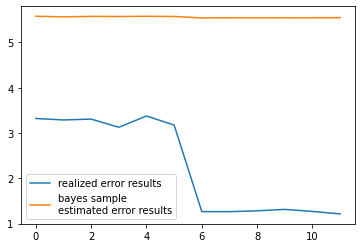

In [23]:
plt.plot(perf_results, label = 'realized error results')
plt.plot(est_bayes_perf_results, label = 'bayes sample\nestimated error results')
plt.legend()

In [24]:
print("Realized", "\tEstimated")
for x,y in zip(perf_results, est_bayes_perf_results):
    print(
        str(round(x, 3)),
        "\t\t"+str(round(y,3))
    ) 

Realized 	Estimated
3.32 		5.576
3.288 		5.564
3.307 		5.574
3.126 		5.571
3.375 		5.575
3.174 		5.572
1.265 		5.54
1.264 		5.541
1.282 		5.543
1.314 		5.541
1.268 		5.543
1.214 		5.545
